<a href="https://colab.research.google.com/github/wincmoriya/pytorch-handson/blob/main/%E3%82%AA%E3%83%BC%E3%83%88%E3%82%A8%E3%83%B3%E3%82%B3%E3%83%BC%E3%83%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## 前処理

In [5]:
transform = transforms.Compose([
                                transforms.ToTensor()
])

In [6]:
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [7]:
# dataloaderに渡す
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [18]:
# クラス定義
class ConvAE(nn.Module):
    def __init__(self):
        super().__init__()
        # エンコーダの設定
        self.en = nn.Sequential(
            # in_channelsはグレースケールなので1
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.de = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=8, out_channels=1, kernel_size=3, padding=1),
            # ReLUを使うよりnn.Tanh()を使った方がlossが下がる傾向にあったらしい
            nn.Tanh()
        )
    def forward(self, x):
        # 圧縮されたxに変換
        x = self.en(x)
        # 再構成された画像
        x = self.de(x)
        return x

#### エンコーダ
* 画像を圧縮していくのでMaxプーリングがある

#### デコーダ
* Maxプーリングの部分が別の関数になる
* 画像を引き伸ばす関数Upsample()を使う

Maxプーリング ： 解像度を落とす\
Upsample : 画像を引き伸ばす


## エンコーダの最後のMaxプーリングがない？
今回は画像サイズが28×28なので一度のMaxプーリングで28×28 -> 14×14にプーリングされる。\
2回目は14×14 -> 7×7\
3回目は割り切れなくなってしまうので最後のMaxプーリングは除外する。


## モデルの作成

In [19]:
model = ConvAE()
model.to(device)

ConvAE(
  (en): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
  )
  (de): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Upsample(scale_factor=2.0, mode=nearest)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): Upsample(scale_factor=2.0, mode=nearest)
    (6): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Tanh()
  )
)

In [20]:
# 損失関数の定義
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
num_epochs = 15
losses = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, imgs)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    running_loss /= len(train_loader)
    losses.append(running_loss)

    print("epoch: {}, loss: {}".format(epoch, running_loss))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch: 0, loss: 0.014524691762030124
epoch: 1, loss: 0.006391957880804936
epoch: 2, loss: 0.005131059135869145
epoch: 3, loss: 0.0046121316296358905
epoch: 4, loss: 0.0043437040105462075
epoch: 5, loss: 0.004156697985281547
epoch: 6, loss: 0.004025500500326355
epoch: 7, loss: 0.003912005696818232
epoch: 8, loss: 0.00381975177899003
epoch: 9, loss: 0.0037375035973886647
epoch: 10, loss: 0.0036639141115049523
epoch: 11, loss: 0.003602949755266309
epoch: 12, loss: 0.00354235065591832
epoch: 13, loss: 0.0034887687627226114
epoch: 14, loss: 0.0034435067710777124


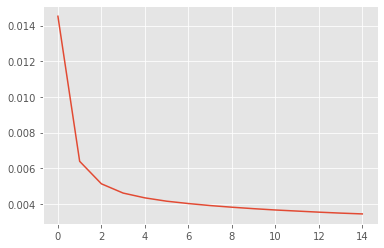

In [22]:
# ggplotにスタイル変更
plt.style.use("ggplot")
plt.plot(losses)

In [23]:
# 圧縮復元してみる
data_iter = iter(train_loader)
imgs, _ = data_iter.next()

In [24]:
img = imgs[0]

In [25]:
img_permute = img.permute(1, 2, 0)

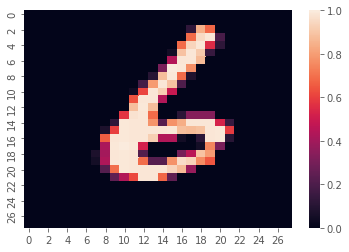

In [26]:
# ヒートマップに2次元のarrayを渡す必要がある
sns.heatmap(img_permute[:, :, 0])

In [27]:
# エンコードする
x_en = model.en(imgs.to(device))

In [28]:
x_en2 = x_en[0].permute(1, 2, 0)

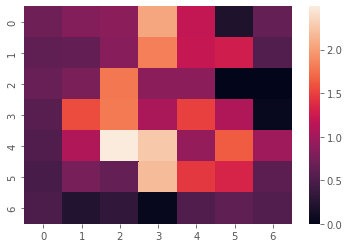

In [29]:
# x_en2で圧縮された表現は全部で16チャネルあるので最初のチャネルだけ見てみる
# フォワードして計算しているのでdetachで勾配計算を切り離す必要がある
# さらにメモリがGPU上にあるのでCPUに移す必要がある
sns.heatmap(x_en2[:, :, 0].detach().to("cpu"))

# 出力結果が最初の画像の圧縮されたチャネルのうちの1つである

### エンコード・デコードする

In [30]:
# こうすればエンコードしてデコードしたものが返ってくる
x_ae = model(imgs.to(device))

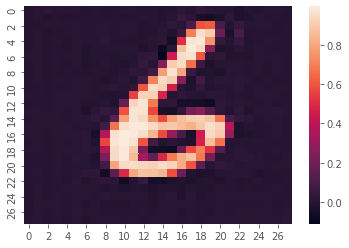

In [31]:
# チャネルラストにする -> 順伝播で計算しているのでdetach -> メモリをCPUに移す -> 2次元にして渡す
sns.heatmap(x_ae[0].permute(1, 2, 0).detach().to("cpu")[:, :, 0])

# 再構成された最初の画像が返ってくる